In [8]:
import matplotlib.pyplot as plt
from get_data import *
import tqdm
import glob
import datetime
from argparse import ArgumentParser
import pickle

In [2]:
date = '2022-01-03'
stock_code = '2330'
st = datetime.datetime.now()
cache_path = os.path.join(CACHE_DIR, stock_code, f'{date}.pkl')
verbose = False


In [3]:
date_ls = [i.replace('.pkl', '') for i in os.listdir(os.path.join(CACHE_DIR, stock_code))]
res_dict = dict()

In [ ]:
def processing_quotes(date, stock_code='2330', fading_limit = 100, verbose = False):
    cache_path = os.path.join(CACHE_DIR, stock_code, f'{date}.pkl')
    df = read_pkl_helper(cache_path)
    df.loc[:,'prev_spread_in_tick'] = df['spread_in_tick'].shift()
    df.loc[:,'prev_BP1'] = df['BP1'].shift()
    df.loc[:,'prev_SP1'] = df['SP1'].shift()
    possible_quotes = df[(df['prev_spread_in_tick']>=2) & (df['spread_in_tick']==1)].copy()
    
    iter_obj = possible_quotes.iterrows() if not verbose else tqdm.tqdm(possible_quotes.iterrows(), desc=f'{date}:Simulation', ncols=200, total=len(possible_quotes))
    for index, row in iter_obj:
        start_time = row['dt']
        side  = 'bid' if row['BP1'] > row['prev_BP1'] else 'ask'
        possible_quotes.loc[index,'side'] = side
        curr_BP = row['BP1']
        curr_SP = row['SP1']
        for _, quotes in df.loc[index+1:].iterrows():
            duration = (quotes['dt'] - start_time).total_seconds() * 1000 ## in ms
            possible_quotes.loc[index, 'duration'] = duration
            if  duration > fading_limit:
                possible_quotes.loc[index, 'res'] = 'REAL'
                break
            elif quotes['spread_in_tick'] >= 2:
                possible_quotes.loc[index, 'res'] = 'FLICK'
                break
            elif (quotes['lastPx'] <= curr_BP and side =='bid') or (quotes['lastPx'] >= curr_SP and side =='ask'):
                possible_quotes.loc[index, 'res'] = 'EXEC'
                break
            else:
                continue
                
    #return possible_quotes
    res_dict[date] = possible_quotes
    return

In [5]:
for date in tqdm.tqdm(date_ls):
    processing_quotes(date)

100%|████████████████████████████████████████████████████████████████████████████████| 181/181 [19:52<00:00,  6.59s/it]


In [6]:
res_dict

{'2022-01-03':              date       time  lastPx  size  volume      SP5      SP4      SP3  \
 905    2022-01-03   90112449     NaN   NaN    3564  62400.0  62300.0  62200.0   
 914    2022-01-03   90112534     NaN   NaN    3564  62400.0  62300.0  62200.0   
 925    2022-01-03   90112602     NaN   NaN    3569  62400.0  62300.0  62200.0   
 927    2022-01-03   90112674     NaN   NaN    3569  62400.0  62300.0  62200.0   
 935    2022-01-03   90113361     NaN   NaN    3588  62300.0  62200.0  62100.0   
 ...           ...        ...     ...   ...     ...      ...      ...      ...   
 36456  2022-01-03   95431621     NaN   NaN   30497  63000.0  62900.0  62800.0   
 36756  2022-01-03   95533617     NaN   NaN   30629  63100.0  63000.0  62900.0   
 42137  2022-01-03  101320099     NaN   NaN   33634  63200.0  63100.0  63000.0   
 42308  2022-01-03  101343090     NaN   NaN   33690  63200.0  63100.0  63000.0   
 43527  2022-01-03  101825149     NaN   NaN   34467  63300.0  63200.0  63100.0   
 


Saving result

In [9]:
with open('res_dict.pickle', 'wb') as handle:
    pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
flickering_quotes = pd.DataFrame()
for key, item in res_dict.items():
    flickering_quotes = pd.concat([flickering_quotes,item[item['res'] == 'FLICK'] ])
flickering_quotes['size'] = np.where(flickering_quotes['side']=='bid', flickering_quotes['BV1'], flickering_quotes['SV1'] )

### Plot of distribution of Duration and Size

Text(0.5, 1.0, 'distribution of flickering duration')

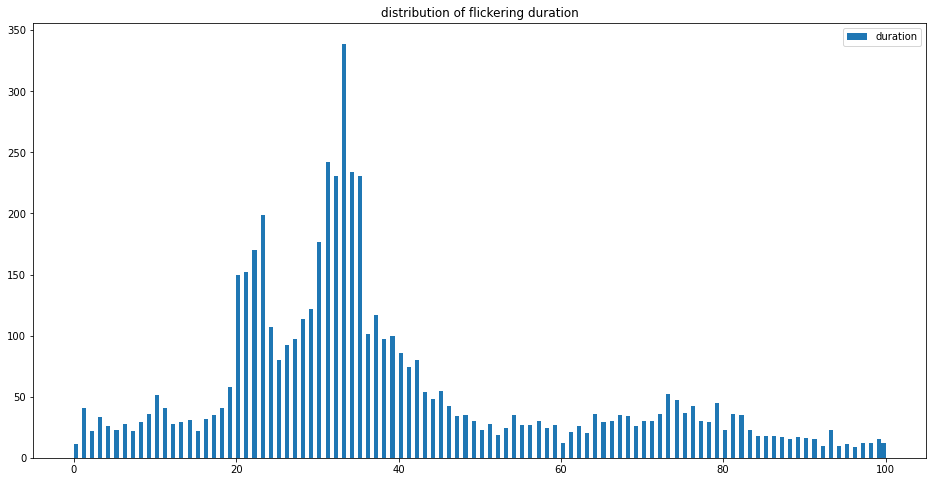

In [26]:
fig,ax = plt.subplots(figsize=(16,8))
ax.hist(flickering_quotes['duration'], bins=200, label='duration')
ax.legend(loc = 'upper right')
ax.set_title('distribution of flickering duration')

Text(0.5, 1.0, 'distribution of flickering size')

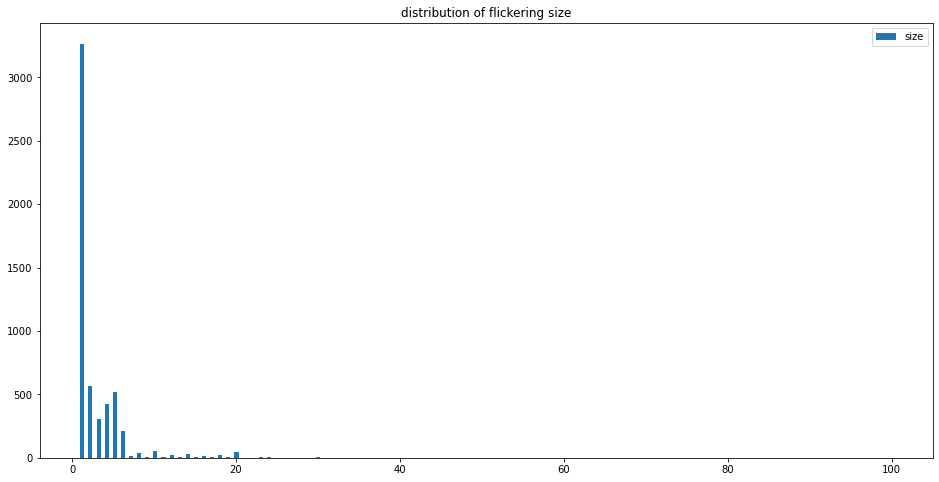

In [29]:
fig,ax = plt.subplots(figsize=(16,8))
ax.hist(flickering_quotes['size'], bins=200, label='size')
ax.legend(loc = 'upper right')
ax.set_title('distribution of flickering size')

### Ploting example

In [1]:
date = '2022-01-03'
ex = res_dict[date]
cache_path = os.path.join(CACHE_DIR, stock_code, f'{date}.pkl')
df = read_pkl_helper(cache_path)
index = 905
index_time = df.loc[index, 'dt']
start_time = index_time - datetime.timedelta(milliseconds = 100)
end_time = index_time + datetime.timedelta(milliseconds = 100)
quotes = df[(df['dt']<end_time) & (df['dt']>start_time)]
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(quotes['dt'],quotes['BP1'], color = 'gray')
ax.plot(quotes['dt'],quotes['SP1'],  color = 'gray')
ax.axvline(index_time, color='violet')
ax.scatter(quotes['dt'], quotes['lastPx'], color='blue', label='Market Trades', alpha=0.7, s=80, marker='D')
ax.legend(loc = 'upper right')

NameError: name 'res_dict' is not defined